[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/broadinstitute/g2papi/blob/main/examples/ex3_large_scale_variant_characterization/large_scale_variant_characterization.ipynb)

# Large Scale Variant Characterization - Training a Model on G2P Portal Features

In [25]:
# @markdown ## Download ClinVar variants

! wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz

! gunzip --force variant_summary.txt.gz

--2025-06-18 21:22:06--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/tab_delimited/variant_summary.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 372178595 (355M) [application/x-gzip]
Saving to: ‘variant_summary.txt.gz’

variant_summary.txt 100%[===================>] 354.94M  21.8MB/s    in 13s     

2025-06-18 21:22:19 (27.8 MB/s) - ‘variant_summary.txt.gz’ saved [372178595/372178595]



## Get Protein Features for the G2P portal Protein Feature API


In [26]:

# @markdown ### Load List of Genes
! pip install g2papi

import g2papi
import pandas as pd

!wget -O "query_results.csv" "https://raw.githubusercontent.com/broadinstitute/g2papi/main/examples/ex1_chaperones/query%20results.csv"

chaperones = pd.read_csv("query_results.csv")
chaperones.head()

--2025-06-18 21:22:54--  https://raw.githubusercontent.com/broadinstitute/g2papi/main/examples/ex1_chaperones/query%20results.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9160 (8.9K) [text/plain]
Saving to: ‘query_results.csv’

query_results.csv   100%[===================>]   8.95K  --.-KB/s    in 0s      

2025-06-18 21:22:54 (75.9 MB/s) - ‘query_results.csv’ saved [9160/9160]



,id,UniProt,Symbol,Name,Target Development Level,IDG Family,Novelty
0,192,P61604,HSPE1,"10 kDa heat shock protein, mitochondrial",Tbio,Other,0.000744
1,908,Q58FF3,HSP90B2P,Putative endoplasmin-like protein,Tdark,Other,NaN
2,909,P14625,HSP90B1,Endoplasmin,Tchem,Other,0.001359
3,1824,Q9HAV7,GRPEL1,"GrpE protein homolog 1, mitochondrial",Tbio,Other,0.001853
4,1825,Q8TAA5,GRPEL2,"GrpE protein homolog 2, mitochondrial",Tbio,Other,0.526602


In [27]:
# @markdown ### Call the G2P portal Protein Feature API

from tqdm.notebook import tqdm

protein_features_by_gene = {}

for entry in tqdm(chaperones.to_dict(orient="records")):
    gene = entry["Symbol"]
    uniprot_id = entry["UniProt"]
    protein_features = g2papi.get_protein_features(gene, uniprot_id)

    protein_features_by_gene[gene] = protein_features


pd.to_pickle(protein_features_by_gene, "protein_features.pkl")   # ~2‑3× smaller if you add compression


  0%|          | 0/110 [00:00<?, ?it/s]

In [28]:
# @markdown Load cached data from file
protein_features_by_gene = pd.read_pickle("protein_features.pkl")


## Protein Feature Engineering

In [29]:
# @markdown ### Define Functions to Pre-process Protein Features

# @markdown For Categorical Features, we will use one-hot encoding, and for quantitative features, we will scale the values.

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import re
from tqdm.notebook import tqdm


def is_uniprot(col):
    return "(UniProt)" in col

def is_ptm(col):
    return col in [
        "Acetylation",
        "Disease-associated PTMs",
        "Methylation",
        "O-GalNAc",
        "O-GlcNAc",
        "Phosphorylation",
        "SNP-associated PTMs",
        "Regulatory sites",
        "Substrate genes",
        "SUMOylation",
        "Ubiquitination",
    ]

def is_pocket(col):
    return col == "Pocket number (fpocket)*"

def is_ppi(col):
    is_pdb_ppi = ("bond (PDB)" in col) or ("interaction (PDB)" in col) \
       or ("bridge (PDB)" in col)
    is_af2_ppi = ("bond (AlphaFold2)" in col) or ("interaction (AlphaFold2)" in col) \
       or ("bridge (AlphaFold2)" in col)

    return is_pdb_ppi or is_af2_ppi

def is_mave_outlier(col):
    return bool(re.match(r'^\d{7,9}-[a-z0-9]-\d{1,3} outliers⁺⁺$', col))


def is_categorical(col):
    categorical_cols = [
        "Amino acid residues",
        "Amino acid properties",
        "Secondary structure (PDBe/SIFTS)",
        "Secondary structure (DSSP 3-state)*",
        "Secondary structure (DSSP 9-state)*"
    ]

    return is_uniprot(col) or col in categorical_cols \
       or is_ptm(col) or is_ppi(col) or is_mave_outlier(col) \
       or is_pocket(col)

def non_nan_always_1(col):

    matches = is_uniprot(col) or is_ptm(col) \
        or is_ppi(col) or is_mave_outlier(col) \
        or is_pocket(col)
    #print(col, matches)
    return matches


# for all columns starting with amino acid columns, normalize quantitative columns and
# use one hot encoding for categorical variables

def normalize_gene_data(gene_data):
    # Make a copy to avoid modifying the original data
    df = gene_data.copy()

    # Excluding chain and AA which are unique identifiers
    amino_acid_cols = [col for col in df.columns if col not in ['residueId', 'AA']]

    # Process each column
    normalized_df = df[['residueId', 'AA']].copy()

    normalized_cols = []

    for col in amino_acid_cols:
        try:
            # Check if column is numeric
            if not is_categorical(col):
                # Normalize numeric columns using StandardScaler
                # First handle any NaN value

                col_data = df[col].fillna(df[col].mean())
                # if col_data is all 0, no need to normalize
                if col_data.sum() != 0 and col_data.nunique() > 1:
                    scaler = StandardScaler()
                    col_data = scaler.fit_transform(col_data.values.reshape(-1, 1))

                normalized_cols.append(pd.DataFrame(
                    col_data,
                    columns=[f"{col}_normalized"],
                    index=df.index
                ))
            else:
                # For categorical columns, apply one-hot encoding
                if non_nan_always_1(col):
                    col_data = df[col].notna().astype(int)

                    normalized_cols.append(pd.DataFrame(
                        col_data,
                        columns=[col],
                        index=df.index
                    ))
                else:
                    # First handle any NaN values
                    #col_data = df[col].fillna('Unknown')
                    col_data = df[col]

                    # Apply one-hot encoding
                    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                    encoded = encoder.fit_transform(col_data.values.reshape(-1, 1))

                    # Create new columns for each category
                    categories = encoder.categories_[0]

                    normalized_cols.append(pd.DataFrame(
                        encoded,
                        columns=[f"{col}_{category}" for category in categories],
                        index=df.index
                    ))
        except:
            #print(f"Failed process for col {col}")
            continue

    all_dfs = [normalized_df] + normalized_cols
    normalized_df = pd.concat(all_dfs, axis=1)

    return normalized_df



In [30]:
# @markdown ### Pre-process Protein Features for Each Gene

normalized_data = []

for entry in tqdm(chaperones.to_dict(orient="records")):
    gene = entry["Symbol"]
    uniprot_id = entry["UniProt"]
    protein_features = protein_features_by_gene[gene]
    normalized_df = normalize_gene_data(protein_features)
    normalized_df["gene"] = gene # add a gene col
    normalized_data.append(normalized_df)


  0%|          | 0/110 [00:00<?, ?it/s]

In [31]:
# @markdown ### Concatenate all data

final_df = pd.concat(normalized_data)


to_drop = []
for col in final_df.columns:
    if is_mave_outlier(col) or "avg_normalized" in col:
        to_drop.append(col)


final_df = final_df.drop(columns=to_drop)


final_df = final_df.fillna(0)

/tmp/ipython-input-31-2473230062.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(normalized_data)


In [32]:
# @markdown # Now make a model to predict - Is a variant breaking a hydrogen bond?






In [33]:
import os
os.listdir()

['.config',
 'pathogenic_snvs.tsv',
 'variant_summary.txt',
 'protein_features.pkl',
 '.ipynb_checkpoints',
 'query_results.csv',
 'variant_summary.txt.gz.1',
 'sample_data']

In [34]:
# @markdown ## Load ClinVar Pathogenic Missense Variants for the genes
import pandas as pd

!awk -F'\t' 'NR==1{for(i=1;i<=NF;i++){if($i=="ClinSigSimple")c=i;else if($i=="Type")t=i;else if($i=="Assembly")a=i;}print;next} ($c=="1" && $t=="single nucleotide variant" && $a=="GRCh38")' variant_summary.txt > pathogenic_snvs.tsv


#clinvar_variants = pd.read_csv("variant_summary.txt", sep="\t")

#pathogenic_variants = clinvar_variants[clinvar_variants["ClinSigSimple"] == 1]
pathogenic_variants = pd.read_csv("pathogenic_snvs.tsv", sep="\t")

pathogenic_labels = ["Pathogenic", "Likely pathogenic", "Pathogenic/Likely pathogenic"]

pathogenic_variants = pathogenic_variants[pathogenic_variants["ClinicalSignificance"].isin(pathogenic_labels)]

columns = pathogenic_variants.columns

# Assembly = GRCh38
# Type = single nucleotide variant
print(pathogenic_variants.shape)
pathogenic_snvs = pathogenic_variants[pathogenic_variants["Type"] == "single nucleotide variant"]
pathogenic_snvs = pathogenic_snvs[pathogenic_snvs["Assembly"] == "GRCh38"]
print(pathogenic_snvs.shape)

# and does not end with "Ter)"
pathogenic_snvs = pathogenic_snvs[~pathogenic_snvs["Name"].str.endswith("Ter)")]
print(pathogenic_snvs.shape)

# Filter for GeneSymbol matching the chaperones dataframe
pathogenic_snvs = pathogenic_snvs[pathogenic_snvs["GeneSymbol"].isin(chaperones["Symbol"])]
print(pathogenic_snvs.shape)

variants = []

for variant in pathogenic_snvs.to_dict(orient="records"):
    gene = variant["GeneSymbol"]
    impact = variant["Name"].split(":")[1]
    has_protein_position = "p." in variant["Name"]
    if not has_protein_position:
        continue
    protein_change = variant["Name"].split("p.")[1].split(")")[0]
    protein_position = int(protein_change[3:][:-3])
    transcript = variant["Name"].split("(")[0]
    variants.append({
        "gene": gene,
        "impact": impact,
        "protein_position": protein_position,
        "transcript": transcript
    })

variants_df = pd.DataFrame(variants)
print(variants_df.shape)

# drop duplicates (same protein position and transcript)
variants_df = variants_df.drop_duplicates(subset=["gene", "protein_position", "transcript"])
print(variants_df.shape)

variants_df.head()

(171281, 43)
(171281, 43)
(106937, 43)
(179, 43)
(110, 4)
(98, 4)


,gene,impact,protein_position,transcript
0,SNCB,c.208G>A (p.Val70Met),70,NM_003085.5
1,HTRA1,c.889G>A (p.Val297Met),297,NM_002775.5
2,HTRA1,c.754G>A (p.Ala252Thr),252,NM_002775.5
3,DCTN1,c.175G>A (p.Gly59Ser),59,NM_004082.5
4,DCTN1,c.221A>C (p.Gln74Pro),74,NM_004082.5


In [35]:
# @markdown ## Use G2P3D API to check transcript map

variant_genes = variants_df["gene"].unique()

canonical_isoform_variants = []
for gene in variant_genes:
    uniprot_id = chaperones[chaperones["Symbol"] == gene]["UniProt"].values[0]
    transcript_map = g2papi.get_gene_transcript_protein_isoform_structure(gene, uniprot_id)

    #print(gene)

    transcripts = variants_df[variants_df["gene"] == gene]["transcript"].values
    transcripts = [t.split(".")[0] for t in transcripts]
    #print(transcripts)
    transcript = transcripts[0]

    refseq_col = "RefSeq mRNA Id"
    transcript_map[refseq_col] = transcript_map[refseq_col].str.split("(").str[0]
    refseq_match = transcript_map[transcript_map[refseq_col] == transcript]
    #print(refseq_match.shape)
    #print(refseq_match.head())

    uniprot_isoform = refseq_match["UniProt Isoform"].values[0]
    is_canonical = uniprot_isoform.endswith("(*)")
    #print(is_canonical)
    if is_canonical:
        canonical_isoform_variants.append(variants_df[variants_df["gene"] == gene])

canonical_isoform_variants_df = pd.concat(canonical_isoform_variants)
print(canonical_isoform_variants_df.shape)
canonical_isoform_variants_df.head()

genes_with_canonical_isoform_variants = canonical_isoform_variants_df["gene"].unique()
print(f"There are {len(genes_with_canonical_isoform_variants)} genes with canonical isoform variants")

def is_pathogenic_variant(gene, protein_position):
    return canonical_isoform_variants_df[(canonical_isoform_variants_df["gene"] == gene) & (canonical_isoform_variants_df["protein_position"] == protein_position)].shape[0] > 0


(93, 4)
There are 18 genes with canonical isoform variants


In [36]:
# @markdown ## Construct Data Labels and Features

# @markdown Filter for genes with ClinVar Pathogenic Variants

final_df = final_df[final_df["gene"].isin(genes_with_canonical_isoform_variants)]

# @markdown Set Hydrogen Bonds as Labels
def is_hydrogen_bond(col):
    return "Hydrogen bond" in col

hb_cols = [col for col in final_df.columns if is_hydrogen_bond(col)]

final_df["pathogenic"] = final_df.apply(lambda row: is_pathogenic_variant(row["gene"], row["residueId"]), axis=1)
final_df_pathogenic = final_df[final_df["pathogenic"]]
final_df_non_pathogenic = final_df[~final_df["pathogenic"]]
# model label: if there is a hydrogen bond present
y = (final_df[hb_cols].sum(axis=1) > 0).astype(int)
y_pathogenic = (final_df_pathogenic[hb_cols].sum(axis=1) > 0).astype(int)
y_non_pathogenic = (final_df_non_pathogenic[hb_cols].sum(axis=1) > 0).astype(int)

# @markdown Get Remaining Columns as Features
cols_to_skip = hb_cols + ["residueId", "AA", "gene", "pathogenic"]
X = final_df.drop(columns=cols_to_skip)
X_pathogenic = final_df_pathogenic.drop(columns=cols_to_skip)
X_non_pathogenic = final_df_non_pathogenic.drop(columns=cols_to_skip)

/tmp/ipython-input-36-2469112956.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df["pathogenic"] = final_df.apply(lambda row: is_pathogenic_variant(row["gene"], row["residueId"]), axis=1)


In [37]:
# @markdown ## Split Data into Training and Testing Sets

test_percentage = 0.2 # @param {type:"number"}

from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_non_pathogenic, y_non_pathogenic, test_size=test_percentage, random_state=42, stratify=y_non_pathogenic
)

# Print dataset sizes
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Positive labels (training): {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Positive labels (test): {y_test.sum()} ({y_test.mean()*100:.2f}%)")

print(f"Pathogenic set: {X_pathogenic.shape[0]} samples")
print(f"Positive labels (pathogenic): {y_pathogenic.sum()} ({y_pathogenic.mean()*100:.2f}%)")

Training set: 7420 samples
Test set: 1856 samples
Positive labels (training): 5295 (71.36%)
Positive labels (test): 1324 (71.34%)
Pathogenic set: 93 samples
Positive labels (pathogenic): 78 (83.87%)


In [38]:
# @markdown ## Fit a Logistic Regression Model to the Training Data

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Initialize a logistic regression model
# You can adjust regularization strength with C parameter (smaller C = stronger regularization)
model = LogisticRegression(C=1.0, max_iter=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

# @markdown ## Evaluate the Model on the Test Set

# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class

# Make predictions on pathogenic data
pathogenic_pred = model.predict(X_pathogenic)
pathogenic_pred_proba = model.predict_proba(X_pathogenic)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Evaluate the model on pathogenic data
pathogenic_accuracy = accuracy_score(y_pathogenic, pathogenic_pred)
pathogenic_roc_auc = roc_auc_score(y_pathogenic, pathogenic_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"Pathogenic Accuracy: {pathogenic_accuracy:.4f}")
print(f"Pathogenic ROC AUC: {pathogenic_roc_auc:.4f}")
print("\nClassification Report on Pathogenic Data:")
print(classification_report(y_pathogenic, pathogenic_pred))

# Feature importance (coefficients)
#feature_importance = pd.DataFrame({
#    'Feature': X_train.columns,
#    'Coefficient': model.coef_[0]
#})
#feature_importance = feature_importance.sort_values('Coefficient', ascending=False)

# Display top positive and negative coefficients
#print("\nTop 10 Most Positive Features:")
#print(feature_importance.head(10))
#print("\nTop 10 Most Negative Features:")
#print(feature_importance.tail(10))


Accuracy: 0.9116
ROC AUC: 0.9559

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       532
           1       0.92      0.96      0.94      1324

    accuracy                           0.91      1856
   macro avg       0.90      0.88      0.89      1856
weighted avg       0.91      0.91      0.91      1856

Pathogenic Accuracy: 0.8925
Pathogenic ROC AUC: 0.9188

Classification Report on Pathogenic Data:
              precision    recall  f1-score   support

           0       0.73      0.53      0.62        15
           1       0.91      0.96      0.94        78

    accuracy                           0.89        93
   macro avg       0.82      0.75      0.78        93
weighted avg       0.88      0.89      0.89        93



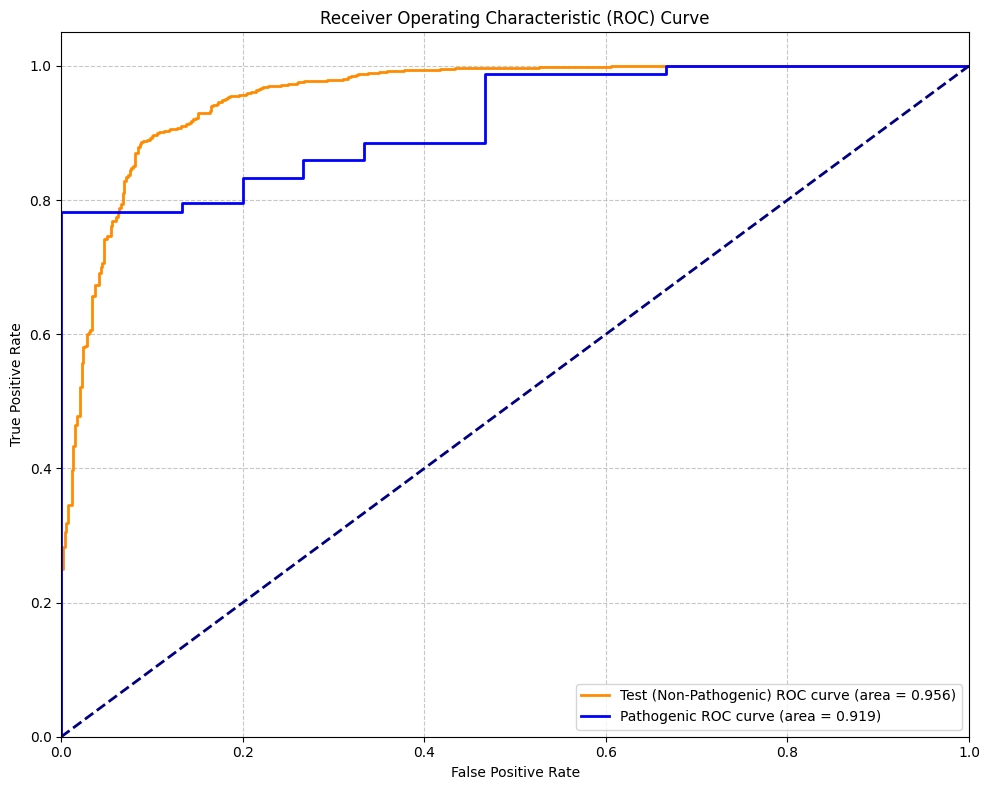

In [39]:
# @markdown ## Plot ROC Curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Calculate ROC curve points for pathogenic data
fpr_pathogenic, tpr_pathogenic, thresholds_pathogenic = roc_curve(y_pathogenic, pathogenic_pred_proba)
roc_auc_pathogenic = auc(fpr_pathogenic, tpr_pathogenic)

# Plot ROC curves for test and pathogenic data
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Test (Non-Pathogenic) ROC curve (area = {roc_auc:.3f})')
plt.plot(fpr_pathogenic, tpr_pathogenic, color='blue', lw=2,
         label=f'Pathogenic ROC curve (area = {roc_auc_pathogenic:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()